In [1]:
import time
import numpy as np
import pandas as pd
import hydroeval as he
import json
import matplotlib.pyplot as plt
import sys
from datetime import date
from datetime import datetime, timedelta

sys.path.insert(0, './CFE')
import bmi_cfe_open
import bmi_cfe_enkf_peturb

sys.path.insert(0, './Assimilation')
import Bmi_da_ENKF_forSBMI


(750.0, 780.0)

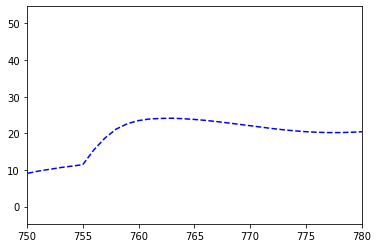

In [2]:
# GET OBSERVATIONS
cfe_obs = bmi_cfe_enkf_peturb.BMI_CFE()
cfe_obs.initialize(cfg_file='./CFE/config_cfe_synthetic.json')
with open(cfe_obs.forcing_file, 'r') as f:
    df_forcing = pd.read_csv(f)
OBSERVATIONS_LIST = []
OBSERVATIONS_LIST_2 = []
for i, precip in enumerate(df_forcing['APCP_surface_0']): #i is RAINRATE
    cfe_obs.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip) 
    cfe_obs.update()
    OBSERVATIONS_LIST.append(cfe_obs.get_value('land_surface_water__runoff_depth') + np.sin(i/5) * 2)
    
    
# for i, precip in enumerate(df_forcing['APCP_surface_NoObsEnd']): #i is RAINRATE
#     cfe_obs.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip) 
#     cfe_obs.update()
#     OBSERVATIONS_LIST_2.append(cfe_obs.get_value('land_surface_water__runoff_depth') + np.sin(i/5) * 2)   
   
#OBSERVATIONS_LIST_2 = OBSERVATIONS_LIST[0:769] # getting observations for EnKF without 18hour forecast

cfe_obs.finalize()
plt.plot(OBSERVATIONS_LIST_2,color = 'green',)
plt.plot(OBSERVATIONS_LIST,color = 'blue', linestyle='dashed')
plt.xlim(750,780)

In [3]:
## Open BMI's for each file
#cfe_open = bmi_cfe_open.BMI_CFE()
cfe_open = bmi_cfe_enkf_peturb.BMI_CFE() #One BMI to rule them all
cfe_peturbed = bmi_cfe_enkf_peturb.BMI_CFE()
cfe_analysis = bmi_cfe_enkf_peturb.BMI_CFE() #true model in the end with updated state vars

enkf = Bmi_da_ENKF_forSBMI.EnKF_wrap()

In [4]:
# Initialize Case study files
cfe_open.initialize(cfg_file='./CFE/config_cfe_synthetic.json')
cfe_peturbed.initialize(cfg_file='./CFE/config_cfe_synthetic.json')
cfe_analysis.initialize(cfg_file='./CFE/config_cfe_synthetic.json')
enkf.initialize(cfg_file='./Assimilation/EnKF_config-synthetic.json') # Need to create this still

initialized 10


In [5]:
print(bmi_cfe_open)
print(bmi_cfe_enkf_peturb)
print(Bmi_da_ENKF_forSBMI)

<module 'bmi_cfe_open' from 'C:\\Users\\zjbut\\Documents\\GitHub\\NextGen---The-Simulators-\\Toy_Model\\./CFE\\bmi_cfe_open.py'>
<module 'bmi_cfe_enkf_peturb' from 'C:\\Users\\zjbut\\Documents\\GitHub\\NextGen---The-Simulators-\\Toy_Model\\./CFE\\bmi_cfe_enkf_peturb.py'>
<module 'Bmi_da_ENKF_forSBMI' from 'C:\\Users\\zjbut\\Documents\\GitHub\\NextGen---The-Simulators-\\Toy_Model\\./Assimilation\\Bmi_da_ENKF_forSBMI.py'>


In [6]:
# with open(cfe_open.forcing_file, 'r') as f:
#     df_forcing = pd.read_csv(f)
    
# print(df_forcing)
#plt.plot(df_forcing['APCP_surface'])

#values = df_forcing['APCP_surface']
#print(values)

In [7]:
#Make empty matrices for plotting
# cfeOpen = []
# cfePeturbed = []
# cfeAnalysis = []
# cfeEnKF = []

n_loop = 2
cfeOpen_ensa=[]
cfeAnalysis_ens=[]
## Loop through 100 different precipitation files for forcing 
for loop in range(n_loop):
    p = 'APCP_surface_' + str(loop)
    
    cfeOpen = []
    cfePeturbed = []
    cfeAnalysis = []
    cfeEnKF = []
    # Initialize Case study files
    cfe_open.initialize(cfg_file='./CFE/config_cfe_synthetic.json')
    cfe_peturbed.initialize(cfg_file='./CFE/config_cfe_synthetic.json')
    cfe_analysis.initialize(cfg_file='./CFE/config_cfe_synthetic.json')
    enkf.initialize(cfg_file='./Assimilation/EnKF_config-synthetic.json') # Need to create this still
    ## Loop through time. Set values for each model and get values
    for i, precip in enumerate(df_forcing[str(p)]): #i is RAINRATE

        # Set values for each model
        cfe_open.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip*3) #value of precip from forcing data in loop
        cfe_peturbed.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip*3)
        cfe_analysis.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip*3)

        obs = OBSERVATIONS_LIST[i]
        enkf.set_value('validity', 1)

        if i>=768:
            enkf.set_value('validity', 0)

        # Update CFE open and peturbed. Get value for peturbed stats. 
        cfe_open.update()
        cfe_peturbed.update()

        # Get state vars from Peturbed. These are values as enkf uses
        soil_storage_avail = cfe_peturbed.get_value('soil_storage_avail_m')
        soil_reservoir_storage_deficit = cfe_peturbed.get_value('soil_reservoir_storage_deficit_out_m')
        surface_runoff = cfe_peturbed.get_value('land_surface_water__runoff_volume_flux')

        # Get values for plotting
        outflow = cfe_open.get_value('land_surface_water__runoff_depth')
        cfeOpen.append(outflow) #for plotting
        outflow_peturb = cfe_peturbed.get_value('land_surface_water__runoff_depth_ens')

        # Get mean and covariance for stats of ensemble runs for EnKF
        outflow_peturb_mean = np.mean(outflow_peturb)
        outflow_peturb_covar = np.cov(outflow_peturb)
        cfePeturbed.append(outflow_peturb_mean) # For plotting

        # Set EnKF value to usgs, mean, and covariance. Get value from it then update
        enkf.set_value('soil_storage_avail_m', soil_storage_avail) #setting soil storage in enkf
        enkf.set_value('soil_reservoir_storage_deficit_m', soil_reservoir_storage_deficit) #setting soil storage in enkf
        enkf.set_value('surface_runoff_depth_m', surface_runoff) #setting soil storage in enkf

        enkf.set_value('x', np.array([outflow_peturb_mean]))
        enkf.set_value('P', np.array([outflow_peturb_covar]))
        enkf.set_value('z', np.array([obs]))
        enkf.update()

        # For plotting
        outflow_enkf = enkf.get_value('enkf')
        cfeEnKF.append(outflow_enkf)

        # Get new EnKF state vars to give back to CFE Analysis
        state_transition_soil_storage = enkf.get_value('soil_storage_avail_m')
        state_transition_soil_res     = enkf.get_value('soil_reservoir_storage_deficit_updated_m')
        state_transition_runoff_factor= enkf.get_value('surface_runoff_ratio')

        # Set value for CFE analysis based on the state variable change from the EnKF factor to get true streamflow
        cfe_analysis.set_value('soil_storage_avail_m', state_transition_soil_storage)    
        cfe_analysis.set_value('soil_reservoir_storage_deficit_m', state_transition_soil_res)  
        cfe_analysis.set_value('state_var_change_runoff',state_transition_runoff_factor)
        cfe_analysis.update() #get new streamflow value based on state var change

        # For plotting
        outflow_analysis = cfe_analysis.get_value('land_surface_water__runoff_depth')
        cfeAnalysis.append(outflow_analysis) 

        # Get values from new CFE analysis to put back into CFE Peturbed to keep look and EnKF going
        cfe_updated_everything_soil_storage = cfe_analysis.get_value('soil_storage_avail_m')
        cfe_updated_everything_soil_res = cfe_analysis.get_value('soil_reservoir_storage_deficit_m')
        cfe_updated_everything_runoff = cfe_analysis.get_value('state_var_change_runoff')

        # Set value from CFE analysis state variables back into CFE Peturbed to continue EnKF loop
        cfe_peturbed.set_value('soil_storage_avail_m', cfe_updated_everything_soil_storage)
        cfe_peturbed.set_value('soil_reservoir_storage_deficit_m', cfe_updated_everything_soil_res)
        cfe_peturbed.set_value('state_var_change_runoff', cfe_updated_everything_runoff)
    
    # predicted values
    cfeOpen_error=cfe_open#.subtract(OBSERVATIONS_LIST[769:])
    cfeAnalysis_error=cfeAnalysis#[769:]#.subtract(OBSERVATIONS_LIST[769:])
    # reaults of 100
    cfeOpen_ensa.append(np.divide(abs(np.subtract(cfeOpen[767:],OBSERVATIONS_LIST[767:])),OBSERVATIONS_LIST[767:]))
    cfeAnalysis_ens.append(np.divide(abs(np.subtract(cfeAnalysis[767:],OBSERVATIONS_LIST[767:])),OBSERVATIONS_LIST[767:]))
    
    # mean of 100
    # print("open",cfeOpen)
    # print("obs2",OBSERVATIONS_LIST)
    # print("analysis-obs",cfeAnalysis_ens)
    cfeOpen_ensa_mean=np.mean(cfeOpen_ensa,axis=0)
    cfeanalys_ensa_mean=np.mean(cfeAnalysis_ens,axis=0)
    # Finalize models
cfe_open.finalize(print_mass_balance=True)
cfe_peturbed.finalize(print_mass_balance=True)
cfe_analysis.finalize(print_mass_balance=True)
enkf.finalize()



initialized 10
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.3121136221931379
EnKF Code predicted, X Post [9.67951554]
surface_runoff_ratio [2.16166509]
Leftover vol 0.0
surface _runoff [2.16166509]
***********over estimaiton ratio [1.]
Observation BMI [9.14803171]
CFE [27.42620563]
enkf [9.67951554]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.2957114578598735
EnKF Code predicted, X Post [16.51511892]
surface_runoff_ratio [1.2623728]
Leftover vol [34.04606283]
surface _runoff [1.2623728]
***********over estimaiton ratio [0.32663633]
Observation BMI [16.75252741]
CFE [50.56118175]
enkf [16.51511892]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.28072802840953426
EnKF Code predicted, X Post [22.19269023]
surface_runoff_ratio [1.50664864]
Leftover vol [31.62748332]
surface _runoff [1.50664864]
***********over estimaiton ratio [0.41234892]
Observation BMI [22.40183725]
CFE [53.8201735

EnKF Code predicted, X Post [0.00407796]
surface_runoff_ratio [0.00048709]
Leftover vol 0.0
surface _runoff [0.00048709]
***********over estimaiton ratio [1.]
Observation BMI [0.23928924]
CFE [0.00599618]
enkf [0.00407796]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.21388626143411793
EnKF Code predicted, X Post [0.25869024]
***********under estimaiton ratio [40.45048327]
Observation BMI [0.629494]
CFE [0.00639523]
enkf [0.25869024]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.2210197691697241
EnKF Code predicted, X Post [0.38989877]
***********under estimaiton ratio [57.46420471]
Observation BMI [0.99485675]
CFE [0.00678507]
enkf [0.38989877]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.22803732534159116
EnKF Code predicted, X Post [0.85854255]
***********under estimaiton ratio [131.95693088]
Observation BMI [1.32081998]
CFE [0.00650623]
enkf [0.85854255]
Beginning--------------

EnKF Code predicted, X Post [6.0339498]
surface_runoff_ratio [0.65395952]
Leftover vol 0.0
surface _runoff [0.65395952]
***********over estimaiton ratio [1.]
Observation BMI [4.23898766]
CFE [9.62561006]
enkf [6.0339498]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.15369689254897423
EnKF Code predicted, X Post [5.06974554]
surface_runoff_ratio [0.65402457]
Leftover vol 0.0
surface _runoff [0.65402457]
***********over estimaiton ratio [1.]
Observation BMI [4.47738074]
CFE [9.1037765]
enkf [5.06974554]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.15103653915668025
EnKF Code predicted, X Post [4.12608722]
surface_runoff_ratio [0.65408512]
Leftover vol 0.0
surface _runoff [0.65408512]
***********over estimaiton ratio [1.]
Observation BMI [4.64721384]
CFE [8.12664945]
enkf [4.12608722]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.14860521675830107
EnKF Code predicted, X Post [5.022321

***********under estimaiton ratio [21.37621891]
Observation BMI [-0.08311006]
CFE [0.01181897]
enkf [0.25264498]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.30400590149575035
EnKF Code predicted, X Post [0.53719281]
***********under estimaiton ratio [40.28053154]
Observation BMI [0.31578458]
CFE [0.01333629]
enkf [0.53719281]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.30967456001887284
EnKF Code predicted, X Post [2.39028553]
surface_runoff_ratio [0.22678993]
Leftover vol [180.61614071]
surface _runoff [0.22678993]
***********over estimaiton ratio [0.01306121]
Observation BMI [2.51593548]
CFE [183.00642623]
enkf [2.39028553]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.2935473938542372
EnKF Code predicted, X Post [4.22983271]
surface_runoff_ratio [0.30135885]
Leftover vol [187.86973961]
surface _runoff [0.30135885]
***********over estimaiton ratio [0.02201896]
Observation BMI 

***********over estimaiton ratio [1.]
Observation BMI [0.67698065]
CFE [5.44138362]
enkf [0.93902035]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.16048901279104388
EnKF Code predicted, X Post [0.7897648]
surface_runoff_ratio [0.25922011]
Leftover vol 0.0
surface _runoff [0.25922011]
***********over estimaiton ratio [1.]
Observation BMI [-0.1041944]
CFE [3.44061966]
enkf [0.7897648]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.16849046582214955
EnKF Code predicted, X Post [0.60994351]
surface_runoff_ratio [0.13533674]
Leftover vol 0.0
surface _runoff [0.13533674]
***********over estimaiton ratio [1.]
Observation BMI [-0.38996545]
CFE [1.27578959]
enkf [0.60994351]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.1763618592773034
EnKF Code predicted, X Post [-0.05429294]
surface_runoff_ratio [0.05682139]
Leftover vol 0.0
surface _runoff [0.05682139]
***********over estimaiton ratio [1

Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.19178680905741985
EnKF Code predicted, X Post [7.2702376]
surface_runoff_ratio [1.57378352]
Leftover vol 0.0
surface _runoff [1.57378352]
***********over estimaiton ratio [1.]
Observation BMI [7.50401145]
CFE [17.22138097]
enkf [7.2702376]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.18580898454947914
EnKF Code predicted, X Post [7.60664573]
surface_runoff_ratio [1.6750788]
Leftover vol 0.0
surface _runoff [1.6750788]
***********over estimaiton ratio [1.]
Observation BMI [7.88496191]
CFE [17.00048339]
enkf [7.60664573]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.18034757264059598
EnKF Code predicted, X Post [8.9296476]
surface_runoff_ratio [1.80601806]
Leftover vol 0.0
surface _runoff [1.80601806]
***********over estimaiton ratio [1.]
Observation BMI [8.28288074]
CFE [18.92460752]
enkf [8.9296476]
Beginning----------------------------

EnKF Code predicted, X Post [0.38420732]
***********under estimaiton ratio [23.52867678]
Observation BMI [-0.17816143]
CFE [0.01632932]
enkf [0.38420732]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.29211697946527393
EnKF Code predicted, X Post [0.11750847]
***********under estimaiton ratio [5.38230757]
Observation BMI [0.2211655]
CFE [0.02183236]
enkf [0.11750847]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.2979788864086267
EnKF Code predicted, X Post [0.41431967]
***********under estimaiton ratio [18.07520462]
Observation BMI [0.61245864]
CFE [0.02292199]
enkf [0.41431967]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.30374551101658886
EnKF Code predicted, X Post [0.29202764]
***********under estimaiton ratio [17.67516903]
Observation BMI [0.98011794]
CFE [0.01652191]
enkf [0.29202764]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.309418402055

Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.2979400580275424
EnKF Code predicted, X Post [-0.58793429]
surface_runoff_ratio [0.00157589]
Leftover vol 0.0
surface _runoff [0.00157589]
***********over estimaiton ratio [1.]
Observation BMI [-0.8966372]
CFE [0.02101373]
enkf [-0.58793429]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.3037073137712194
EnKF Code predicted, X Post [-0.22428571]
surface_runoff_ratio [0.00157428]
Leftover vol 0.0
surface _runoff [0.00157428]
***********over estimaiton ratio [1.]
Observation BMI [-1.23153392]
CFE [0.02090838]
enkf [-0.22428571]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.30938082568693026
EnKF Code predicted, X Post [3.73933015]
surface_runoff_ratio [1.08154656]
Leftover vol 0.0
surface _runoff [1.08154656]
***********over estimaiton ratio [1.]
Observation BMI [3.04659398]
CFE [11.72686956]
enkf [3.73933015]
Beginning---------------------

Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.1521562365476895
EnKF Code predicted, X Post [7.09268012]
surface_runoff_ratio [0.78753216]
Leftover vol 0.0
surface _runoff [0.78753216]
***********over estimaiton ratio [1.]
Observation BMI [6.49420743]
CFE [8.60838512]
enkf [7.09268012]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.16029313464614703
EnKF Code predicted, X Post [4.04408945]
surface_runoff_ratio [0.41022901]
Leftover vol 0.0
surface _runoff [0.41022901]
***********over estimaiton ratio [1.]
Observation BMI [3.48029628]
CFE [6.06963188]
enkf [4.04408945]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.16829777157752224
EnKF Code predicted, X Post [2.08062071]
surface_runoff_ratio [0.20594953]
Leftover vol 0.0
surface _runoff [0.20594953]
***********over estimaiton ratio [1.]
Observation BMI [1.55873198]
CFE [2.80856902]
enkf [2.08062071]
Beginning--------------------------

EnKF Code predicted, X Post [17.91517169]
surface_runoff_ratio [1.25639226]
Leftover vol [37.65171099]
surface _runoff [1.25639226]
***********over estimaiton ratio [0.32240736]
Observation BMI [18.076595]
CFE [55.56688268]
enkf [17.91517169]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.2311212877658102
EnKF Code predicted, X Post [17.24701407]
surface_runoff_ratio [1.86477264]
Leftover vol 0.0
surface _runoff [1.86477264]
***********over estimaiton ratio [1.]
Observation BMI [18.02587883]
CFE [26.43429987]
enkf [17.24701407]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.22173153946851432
EnKF Code predicted, X Post [19.04691345]
surface_runoff_ratio [2.98331312]
Leftover vol 0.0
surface _runoff [2.98331312]
***********over estimaiton ratio [1.]
Observation BMI [17.91302936]
CFE [30.18936459]
enkf [19.04691345]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.21315374368209405
EnKF Co

EnKF Code predicted, X Post [12.96331981]
surface_runoff_ratio [2.46148876]
Leftover vol 0.0
surface _runoff [2.46148876]
***********over estimaiton ratio [1.]
Observation BMI [13.14485387]
CFE [24.90750833]
enkf [12.96331981]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.26494682383187196
EnKF Code predicted, X Post [15.88969042]
surface_runoff_ratio [1.34288502]
Leftover vol [22.00385017]
surface _runoff [1.34288502]
***********over estimaiton ratio [0.41932451]
Observation BMI [15.34116778]
CFE [37.89354059]
enkf [15.88969042]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.25262971633382103
EnKF Code predicted, X Post [16.62183415]
surface_runoff_ratio [2.83583442]
Leftover vol 0.0
surface _runoff [2.83583442]
***********over estimaiton ratio [1.]
Observation BMI [16.64562238]
CFE [34.22168572]
enkf [16.62183415]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.24137772827224413
EnKF

Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.2216922166517371
EnKF Code predicted, X Post [22.88927352]
surface_runoff_ratio [1.64124725]
Leftover vol [56.27261646]
surface _runoff [1.64124725]
***********over estimaiton ratio [0.28914511]
Observation BMI [22.86175566]
CFE [79.16188999]
enkf [22.88927352]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.2131143930532844
EnKF Code predicted, X Post [22.55109899]
***********under estimaiton ratio [1.84582903]
Observation BMI [22.47579707]
CFE [12.21732819]
enkf [22.55109899]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.2052786161403216
EnKF Code predicted, X Post [22.0460705]
surface_runoff_ratio [1.86581785]
Leftover vol [26.86277979]
surface _runoff [1.86581785]
***********over estimaiton ratio [0.45075831]
Observation BMI [22.07855993]
CFE [48.90885029]
enkf [22.0460705]
Beginning----------------------------
self.f 1.0
soil_storage_

EnKF Code predicted, X Post [0.07791613]
***********under estimaiton ratio [4.03104313]
Observation BMI [0.84122239]
CFE [0.01932902]
enkf [0.07791613]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.25474862573445334
EnKF Code predicted, X Post [0.09337552]
***********under estimaiton ratio [5.90556663]
Observation BMI [0.46253905]
CFE [0.01581144]
enkf [0.09337552]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.2612179363857765
EnKF Code predicted, X Post [-0.05726426]
surface_runoff_ratio [0.00159118]
Leftover vol 0.0
surface _runoff [0.00159118]
***********over estimaiton ratio [1.]
Observation BMI [0.06621932]
CFE [0.01436659]
enkf [-0.05726426]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.2675820916613523
EnKF Code predicted, X Post [0.23573339]
***********under estimaiton ratio [12.86439033]
Observation BMI [-0.33193698]
CFE [0.01832449]
enkf [0.23573339]
Beginning-------------

Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.15046745711248632
EnKF Code predicted, X Post [26.26638412]
surface_runoff_ratio [2.13355819]
Leftover vol [18.53608316]
surface _runoff [2.13355819]
***********over estimaiton ratio [0.58627093]
Observation BMI [25.95891971]
CFE [44.80246728]
enkf [26.26638412]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.14805152122575682
EnKF Code predicted, X Post [25.76480645]
surface_runoff_ratio [2.01799303]
Leftover vol [19.63199078]
surface _runoff [2.01799303]
***********over estimaiton ratio [0.56754679]
Observation BMI [25.59265039]
CFE [45.39679723]
enkf [25.76480645]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.145844667754073
EnKF Code predicted, X Post [24.61647409]
surface_runoff_ratio [1.67373662]
Leftover vol [26.34577097]
surface _runoff [1.67373662]
***********over estimaiton ratio [0.48303355]
Observation BMI [25.20230144]
CFE [50

EnKF Code predicted, X Post [-0.12292122]
surface_runoff_ratio [0.00154722]
Leftover vol 0.0
surface _runoff [0.00154722]
***********over estimaiton ratio [1.]
Observation BMI [-1.12710062]
CFE [0.02287256]
enkf [-0.12292122]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.36597109579385767
EnKF Code predicted, X Post [-0.53798185]
surface_runoff_ratio [0.00154255]
Leftover vol 0.0
surface _runoff [0.00154255]
***********over estimaiton ratio [1.]
Observation BMI [-1.42983601]
CFE [0.01461575]
enkf [-0.53798185]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.3706325413941711
EnKF Code predicted, X Post [-1.14100282]
surface_runoff_ratio [0.00153765]
Leftover vol 0.0
surface _runoff [0.00153765]
***********over estimaiton ratio [1.]
Observation BMI [-1.67478965]
CFE [0.01678297]
enkf [-1.14100282]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.375218217551642
EnKF Code predicted, X Post 

EnKF Code predicted, X Post [9.58793566]
surface_runoff_ratio [1.57073738]
Leftover vol 0.0
surface _runoff [1.57073738]
***********over estimaiton ratio [1.]
Observation BMI [9.2048049]
CFE [18.78646336]
enkf [9.58793566]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.17772342136902697
EnKF Code predicted, X Post [3.83007759]
surface_runoff_ratio [0.81771317]
Leftover vol 0.0
surface _runoff [0.81771317]
***********over estimaiton ratio [1.]
Observation BMI [3.57388876]
CFE [13.4595079]
enkf [3.83007759]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.18544473779710335
EnKF Code predicted, X Post [1.83733668]
surface_runoff_ratio [0.34685821]
Leftover vol 0.0
surface _runoff [0.34685821]
***********over estimaiton ratio [1.]
Observation BMI [0.51875902]
CFE [4.24753684]
enkf [1.83733668]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.19304054812815952
EnKF Code predicted, X Post [1.423

Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.36221345788773773
EnKF Code predicted, X Post [-1.48486498]
surface_runoff_ratio [0.00144299]
Leftover vol 0.0
surface _runoff [0.00144299]
***********over estimaiton ratio [1.]
Observation BMI [-1.71076313]
CFE [0.0181697]
enkf [-1.48486498]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.3669359819935114
EnKF Code predicted, X Post [-0.49064483]
surface_runoff_ratio [0.00143971]
Leftover vol 0.0
surface _runoff [0.00143971]
***********over estimaiton ratio [1.]
Observation BMI [-1.87601808]
CFE [0.01911702]
enkf [-0.49064483]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.3715817438561986
EnKF Code predicted, X Post [-0.56918511]
surface_runoff_ratio [0.00143622]
Leftover vol 0.0
surface _runoff [0.00143622]
***********over estimaiton ratio [1.]
Observation BMI [-1.9657554]
CFE [0.01968317]
enkf [-0.56918511]
Beginning--------------------

EnKF Code predicted, X Post [-0.84264773]
surface_runoff_ratio [0.00123824]
Leftover vol 0.0
surface _runoff [0.00123824]
***********over estimaiton ratio [1.]
Observation BMI [-1.94043848]
CFE [0.01928365]
enkf [-0.84264773]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.4863264888855787
EnKF Code predicted, X Post [-0.71928663]
surface_runoff_ratio [0.00122971]
Leftover vol 0.0
surface _runoff [0.00122971]
***********over estimaiton ratio [1.]
Observation BMI [-1.98427576]
CFE [0.02043613]
enkf [-0.71928663]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.4890316183857836
EnKF Code predicted, X Post [-0.68227351]
surface_runoff_ratio [0.00122109]
Leftover vol 0.0
surface _runoff [0.00122109]
***********over estimaiton ratio [1.]
Observation BMI [-1.9483842]
CFE [0.01972833]
enkf [-0.68227351]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.49169277737284245
EnKF Code predicted, X Post 

EnKF Code predicted, X Post [-0.41448832]
surface_runoff_ratio [0.00117391]
Leftover vol 0.0
surface _runoff [0.00117391]
***********over estimaiton ratio [1.]
Observation BMI [-1.7334074]
CFE [0.0192326]
enkf [-0.41448832]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.2731978348386602
EnKF Code predicted, X Post [0.02842741]
***********under estimaiton ratio [1.50534664]
Observation BMI [-1.50556182]
CFE [0.01888429]
enkf [0.02842741]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.2793672629182292
EnKF Code predicted, X Post [-0.35202633]
surface_runoff_ratio [0.00117918]
Leftover vol 0.0
surface _runoff [0.00117918]
***********over estimaiton ratio [1.]
Observation BMI [-1.21709904]
CFE [0.01736954]
enkf [-0.35202633]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.2854364100617264
EnKF Code predicted, X Post [-0.64320581]
surface_runoff_ratio [0.00118171]
Leftover vol 0.0
surface _r

soil_storage_deficit_from CFE 0.2106849725556077
EnKF Code predicted, X Post [-0.84419888]
surface_runoff_ratio [0.0175263]
Leftover vol 0.0
surface _runoff [0.0175263]
***********over estimaiton ratio [1.]
Observation BMI [-1.7864482]
CFE [0.21115823]
enkf [-0.84419888]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.2178705156243489
EnKF Code predicted, X Post [-0.61764149]
surface_runoff_ratio [0.00128737]
Leftover vol 0.0
surface _runoff [0.00128737]
***********over estimaiton ratio [1.]
Observation BMI [-1.98307485]
CFE [0.01250774]
enkf [-0.61764149]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.22493926132130393
EnKF Code predicted, X Post [-1.15747742]
surface_runoff_ratio [0.00129215]
Leftover vol 0.0
surface _runoff [0.00129215]
***********over estimaiton ratio [1.]
Observation BMI [-1.9336612]
CFE [0.01964326]
enkf [-1.15747742]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0

EnKF Code predicted, X Post [-0.39187026]
surface_runoff_ratio [0.00133364]
Leftover vol 0.0
surface _runoff [0.00133364]
***********over estimaiton ratio [1.]
Observation BMI [-1.91620753]
CFE [0.02080293]
enkf [-0.39187026]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.39109168667501815
EnKF Code predicted, X Post [-1.41748733]
surface_runoff_ratio [0.00133123]
Leftover vol 0.0
surface _runoff [0.00133123]
***********over estimaiton ratio [1.]
Observation BMI [-1.97957558]
CFE [0.01578652]
enkf [-1.41748733]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.39534480976378783
EnKF Code predicted, X Post [-1.27706538]
surface_runoff_ratio [0.00132857]
Leftover vol 0.0
surface _runoff [0.00132857]
***********over estimaiton ratio [1.]
Observation BMI [-1.96335311]
CFE [0.02067934]
enkf [-1.27706538]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.39952880048581785
EnKF Code predicted, X Po

***********over estimaiton ratio [1.]
Observation BMI [-1.91952833]
CFE [0.01749886]
enkf [-1.57116152]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.5028683522739794
EnKF Code predicted, X Post [-0.72037017]
surface_runoff_ratio [0.0011344]
Leftover vol 0.0
surface _runoff [0.0011344]
***********over estimaiton ratio [1.]
Observation BMI [-1.77987744]
CFE [0.01468484]
enkf [-0.72037017]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.5053046021432743
EnKF Code predicted, X Post [-0.57113856]
surface_runoff_ratio [0.00112628]
Leftover vol 0.0
surface _runoff [0.00112628]
***********over estimaiton ratio [1.]
Observation BMI [-1.56869493]
CFE [0.01226051]
enkf [-0.57113856]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.507701252001961
EnKF Code predicted, X Post [-0.44886816]
surface_runoff_ratio [0.00111809]
Leftover vol 0.0
surface _runoff [0.00111809]
***********over estimaiton rati

Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.4008015372709657
EnKF Code predicted, X Post [9.74082504]
surface_runoff_ratio [2.56366314]
Leftover vol 0.0
surface _runoff [2.56366314]
***********over estimaiton ratio [1.]
Observation BMI [9.69106678]
CFE [36.99266981]
enkf [9.74082504]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.37676997735144757
EnKF Code predicted, X Post [10.19604629]
surface_runoff_ratio [2.59020896]
Leftover vol 0.0
surface _runoff [2.59020896]
***********over estimaiton ratio [1.]
Observation BMI [10.1573821]
CFE [34.87311357]
enkf [10.19604629]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.3548117115648972
EnKF Code predicted, X Post [11.2518833]
surface_runoff_ratio [2.61672536]
Leftover vol 0.0
surface _runoff [2.61672536]
***********over estimaiton ratio [1.]
Observation BMI [10.65412368]
CFE [36.59142665]
enkf [11.2518833]
Beginning---------------------

initialized 10
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.3121136221931379
EnKF Code predicted, X Post [9.47976518]
surface_runoff_ratio [0.64348192]
Leftover vol [30.37199203]
surface _runoff [0.64348192]
***********over estimaiton ratio [0.23787571]
Observation BMI [9.14803171]
CFE [39.85175721]
enkf [9.47976518]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.29570818267191123
EnKF Code predicted, X Post [16.17811528]
surface_runoff_ratio [2.90870637]
Leftover vol 0.0
surface _runoff [2.90870637]
***********over estimaiton ratio [1.]
Observation BMI [16.75252741]
CFE [37.5401125]
enkf [16.17811528]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.28072008098208756
EnKF Code predicted, X Post [22.0468905]
surface_runoff_ratio [1.6792397]
Leftover vol [51.2243397]
surface _runoff [1.6792397]
***********over estimaiton ratio [0.30089423]
Observation BMI [22.40183725]
CFE [73.27123021]

Observation BMI [1.67729314]
CFE [9.38643081]
enkf [1.41852797]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12338257149822263
EnKF Code predicted, X Post [1.84671439]
surface_runoff_ratio [0.17987384]
Leftover vol [10.73175599]
surface _runoff [0.17987384]
***********over estimaiton ratio [0.1468155]
Observation BMI [2.03536169]
CFE [12.57847038]
enkf [1.84671439]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12331508677341618
EnKF Code predicted, X Post [2.64440566]
surface_runoff_ratio [0.1846101]
Leftover vol [10.20254512]
surface _runoff [0.1846101]
***********over estimaiton ratio [0.20583917]
Observation BMI [2.4218911]
CFE [12.84695077]
enkf [2.64440566]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12326868384251044
EnKF Code predicted, X Post [2.54282186]
surface_runoff_ratio [0.69095278]
Leftover vol 0.0
surface _runoff [0.69095278]
***********over estimaiton ratio [1.]


Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12282093221901558
EnKF Code predicted, X Post [6.58294725]
surface_runoff_ratio [0.57264319]
Leftover vol [17.97004427]
surface _runoff [0.57264319]
***********over estimaiton ratio [0.26811182]
Observation BMI [5.91488172]
CFE [24.55299152]
enkf [6.58294725]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12279847881464556
EnKF Code predicted, X Post [6.35972828]
surface_runoff_ratio [0.67376887]
Leftover vol [9.86083071]
surface _runoff [0.67376887]
***********over estimaiton ratio [0.39207824]
Observation BMI [5.51840921]
CFE [16.22055899]
enkf [6.35972828]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12278060833005944
EnKF Code predicted, X Post [6.00669242]
surface_runoff_ratio [0.48303741]
Leftover vol [11.50673813]
surface _runoff [0.48303741]
***********over estimaiton ratio [0.34297635]
Observation BMI [5.1225465]
CFE [17.5134305

Leftover vol [29.22445333]
surface _runoff [0.65944694]
***********over estimaiton ratio [0.26892739]
Observation BMI [9.98517707]
CFE [39.97476186]
enkf [10.75030854]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12259114435417628
EnKF Code predicted, X Post [10.19336637]
surface_runoff_ratio [0.66642329]
Leftover vol [24.05121794]
surface _runoff [0.66642329]
***********over estimaiton ratio [0.2976636]
Observation BMI [10.17271647]
CFE [34.24458431]
enkf [10.19336637]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12258799432171807
EnKF Code predicted, X Post [10.33535296]
surface_runoff_ratio [1.7516655]
Leftover vol 0.0
surface _runoff [1.7516655]
***********over estimaiton ratio [1.]
Observation BMI [10.28634981]
CFE [19.75269431]
enkf [10.33535296]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12258956198366489
EnKF Code predicted, X Post [11.22128083]
surface_runoff_ratio [0.

Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12266793324491909
EnKF Code predicted, X Post [9.51661357]
surface_runoff_ratio [0.77912521]
Leftover vol [10.9963557]
surface _runoff [0.77912521]
***********over estimaiton ratio [0.46393155]
Observation BMI [9.43764719]
CFE [20.51296928]
enkf [9.51661357]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12266107397942172
EnKF Code predicted, X Post [6.08256801]
surface_runoff_ratio [1.47129343]
Leftover vol 0.0
surface _runoff [1.47129343]
***********over estimaiton ratio [1.]
Observation BMI [6.03462722]
CFE [15.20045205]
enkf [6.08256801]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12265582731405256
EnKF Code predicted, X Post [5.08356031]
surface_runoff_ratio [0.2783919]
Leftover vol [19.47310484]
surface _runoff [0.2783919]
***********over estimaiton ratio [0.20701346]
Observation BMI [3.46342928]
CFE [24.55666515]
enkf [5.08356031

EnKF Code predicted, X Post [1.37237433]
surface_runoff_ratio [0.73502462]
Leftover vol 0.0
surface _runoff [0.73502462]
***********over estimaiton ratio [1.]
Observation BMI [0.32957033]
CFE [9.92870422]
enkf [1.37237433]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12258548069464126
EnKF Code predicted, X Post [-0.21564109]
surface_runoff_ratio [-0.02064882]
Leftover vol [14.72757643]
surface _runoff [-0.02064882]
***********over estimaiton ratio [-0.01485957]
Observation BMI [-0.46852133]
CFE [14.51193534]
enkf [-0.21564109]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12258552390114774
EnKF Code predicted, X Post [-0.05653959]
surface_runoff_ratio [-0.00371096]
Leftover vol [14.96273906]
surface _runoff [-0.00371096]
***********over estimaiton ratio [-0.00379303]
Observation BMI [-0.95889117]
CFE [14.90619947]
enkf [-0.05653959]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12

CFE [10.759407]
enkf [2.32713035]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12272993675254673
EnKF Code predicted, X Post [1.41373316]
surface_runoff_ratio [0.10460732]
Leftover vol [19.37216727]
surface _runoff [0.10460732]
***********over estimaiton ratio [0.06801404]
Observation BMI [1.97924643]
CFE [20.78590043]
enkf [1.41373316]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12271876396536163
EnKF Code predicted, X Post [2.05500247]
surface_runoff_ratio [1.08820396]
Leftover vol 0.0
surface _runoff [1.08820396]
***********over estimaiton ratio [1.]
Observation BMI [2.02017731]
CFE [10.26116733]
enkf [2.05500247]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.1227148629047845
EnKF Code predicted, X Post [2.28068073]
surface_runoff_ratio [0.24265116]
Leftover vol [14.29484681]
surface _runoff [0.24265116]
***********over estimaiton ratio [0.13759325]
Observation BMI [1.98137273

EnKF Code predicted, X Post [21.55270345]
***********under estimaiton ratio [-0.56568971]
Observation BMI [21.33446957]
CFE [-38.09986821]
enkf [21.55270345]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12256972953886847
EnKF Code predicted, X Post [20.67353424]
***********under estimaiton ratio [-0.71999478]
Observation BMI [21.17444522]
CFE [-28.71344998]
enkf [20.67353424]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12256848741098358
EnKF Code predicted, X Post [20.62216804]
***********under estimaiton ratio [-0.44407636]
Observation BMI [20.94494128]
CFE [-46.4383375]
enkf [20.62216804]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12256655255000104
EnKF Code predicted, X Post [20.52892533]
***********under estimaiton ratio [-0.40018411]
Observation BMI [20.65513704]
CFE [-51.29870227]
enkf [20.52892533]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_fr

EnKF Code predicted, X Post [8.6027221]
surface_runoff_ratio [0.8595284]
Leftover vol [22.87507674]
surface _runoff [0.8595284]
***********over estimaiton ratio [0.27329491]
Observation BMI [9.30469765]
CFE [31.47779884]
enkf [8.6027221]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12268509576878073
EnKF Code predicted, X Post [15.96796519]
surface_runoff_ratio [1.41680619]
Leftover vol [19.54949204]
surface _runoff [1.41680619]
***********over estimaiton ratio [0.44958075]
Observation BMI [15.09510713]
CFE [35.51745723]
enkf [15.96796519]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12267269914738743
EnKF Code predicted, X Post [19.50650743]
surface_runoff_ratio [1.26111839]
Leftover vol [34.9396359]
surface _runoff [1.26111839]
***********over estimaiton ratio [0.35827161]
Observation BMI [19.25529493]
CFE [54.44614333]
enkf [19.50650743]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from 

Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.1226020401247504
EnKF Code predicted, X Post [26.87511629]
surface_runoff_ratio [2.05196543]
Leftover vol [29.67253428]
surface _runoff [2.05196543]
***********over estimaiton ratio [0.47526495]
Observation BMI [26.98133361]
CFE [56.54765057]
enkf [26.87511629]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12259677998912566
EnKF Code predicted, X Post [26.48893138]
surface_runoff_ratio [2.20818097]
Leftover vol [24.71291376]
surface _runoff [2.20818097]
***********over estimaiton ratio [0.5173433]
Observation BMI [26.91677379]
CFE [51.20184515]
enkf [26.48893138]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12259212257420282
EnKF Code predicted, X Post [26.76475722]
surface_runoff_ratio [1.65245804]
Leftover vol [41.15678517]
surface _runoff [1.65245804]
***********over estimaiton ratio [0.39405403]
Observation BMI [26.77518251]
CFE [67

surface_runoff_ratio [-0.11930764]
Leftover vol [19.89451069]
surface _runoff [-0.11930764]
***********over estimaiton ratio [-0.08801308]
Observation BMI [-1.79045771]
CFE [18.28517607]
enkf [-1.60933462]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12279052019807768
EnKF Code predicted, X Post [13.60091859]
***********under estimaiton ratio [2.78375993]
Observation BMI [14.8887333]
CFE [4.88580874]
enkf [13.60091859]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12276827126726675
EnKF Code predicted, X Post [27.75363956]
surface_runoff_ratio [1.95106644]
Leftover vol [152.89675854]
surface _runoff [1.95106644]
***********over estimaiton ratio [0.15363177]
Observation BMI [28.1389518]
CFE [180.6503981]
enkf [27.75363956]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12274805875222561
EnKF Code predicted, X Post [37.83609112]
surface_runoff_ratio [3.78638163]
Leftover vol [67.71551

EnKF Code predicted, X Post [1.57342488]
surface_runoff_ratio [0.1129653]
Leftover vol [17.3318022]
surface _runoff [0.1129653]
***********over estimaiton ratio [0.08322698]
Observation BMI [1.07372079]
CFE [18.90522708]
enkf [1.57342488]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.1227529625244852
EnKF Code predicted, X Post [1.86152915]
surface_runoff_ratio [0.91498133]
Leftover vol 0.0
surface _runoff [0.91498133]
***********over estimaiton ratio [1.]
Observation BMI [0.7151262]
CFE [9.77565173]
enkf [1.86152915]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12299182892643135
EnKF Code predicted, X Post [2.00950051]
surface_runoff_ratio [0.68145733]
Leftover vol 0.0
surface _runoff [0.68145733]
***********over estimaiton ratio [1.]
Observation BMI [0.32875864]
CFE [8.1435423]
enkf [2.00950051]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12301608177632639
EnKF Code predicted, 

Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.1226449214017592
EnKF Code predicted, X Post [15.58498273]
surface_runoff_ratio [0.96948903]
Leftover vol [20.49532057]
surface _runoff [0.96948903]
***********over estimaiton ratio [0.43195265]
Observation BMI [15.55157905]
CFE [36.0803033]
enkf [15.58498273]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12263790432825039
EnKF Code predicted, X Post [15.6394509]
surface_runoff_ratio [1.27332906]
Leftover vol [15.09964687]
surface _runoff [1.27332906]
***********over estimaiton ratio [0.50878041]
Observation BMI [15.72840505]
CFE [30.73909777]
enkf [15.6394509]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12263004548562972
EnKF Code predicted, X Post [15.65371881]
surface_runoff_ratio [1.46615043]
Leftover vol [9.83333188]
surface _runoff [1.46615043]
***********over estimaiton ratio [0.61418322]
Observation BMI [15.83014385]
CFE [25.48

Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12265854718049085
EnKF Code predicted, X Post [-0.47860975]
surface_runoff_ratio [-0.04192077]
Leftover vol [12.80545021]
surface _runoff [-0.04192077]
***********over estimaiton ratio [-0.03882664]
Observation BMI [-1.60667635]
CFE [12.32684046]
enkf [-0.47860975]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12270076006320929
EnKF Code predicted, X Post [-1.1082634]
surface_runoff_ratio [-0.08739378]
Leftover vol [10.10563076]
surface _runoff [-0.08739378]
***********over estimaiton ratio [-0.12317641]
Observation BMI [-1.34213677]
CFE [8.99736736]
enkf [-1.1082634]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12268941677640421
EnKF Code predicted, X Post [-0.3783439]
surface_runoff_ratio [0.3443983]
Leftover vol 0.0
surface _runoff [0.3443983]
***********over estimaiton ratio [1.]
Observation BMI [-1.02343159]
CFE [3.19000852]
enkf [

EnKF Code predicted, X Post [0.99050538]
surface_runoff_ratio [0.09073977]
Leftover vol [10.42208741]
surface _runoff [0.09073977]
***********over estimaiton ratio [0.08679057]
Observation BMI [0.3571211]
CFE [11.41259279]
enkf [0.99050538]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.1228392037178121
EnKF Code predicted, X Post [0.91704105]
surface_runoff_ratio [0.74292395]
Leftover vol 0.0
surface _runoff [0.74292395]
***********over estimaiton ratio [1.]
Observation BMI [-0.04127616]
CFE [10.28242585]
enkf [0.91704105]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12286805619616104
EnKF Code predicted, X Post [0.03120948]
surface_runoff_ratio [0.00229801]
Leftover vol [23.54716643]
surface _runoff [0.00229801]
***********over estimaiton ratio [0.00132365]
Observation BMI [-0.43741643]
CFE [23.57837591]
enkf [0.03120948]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.1228424785069

Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12262335653669243
EnKF Code predicted, X Post [22.80189738]
surface_runoff_ratio [1.75056427]
Leftover vol [22.80646429]
surface _runoff [1.75056427]
***********over estimaiton ratio [0.49994993]
Observation BMI [22.64192681]
CFE [45.60836167]
enkf [22.80189738]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.1226176043833137
EnKF Code predicted, X Post [23.9235649]
surface_runoff_ratio [3.66267644]
Leftover vol 0.0
surface _runoff [3.66267644]
***********over estimaiton ratio [1.]
Observation BMI [23.49113336]
CFE [32.13165895]
enkf [23.9235649]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.12261108112774743
EnKF Code predicted, X Post [24.17963876]
surface_runoff_ratio [2.00556495]
Leftover vol [38.52277796]
surface _runoff [2.00556495]
***********over estimaiton ratio [0.38562531]
Observation BMI [23.93237428]
CFE [62.70241672]
enkf [24

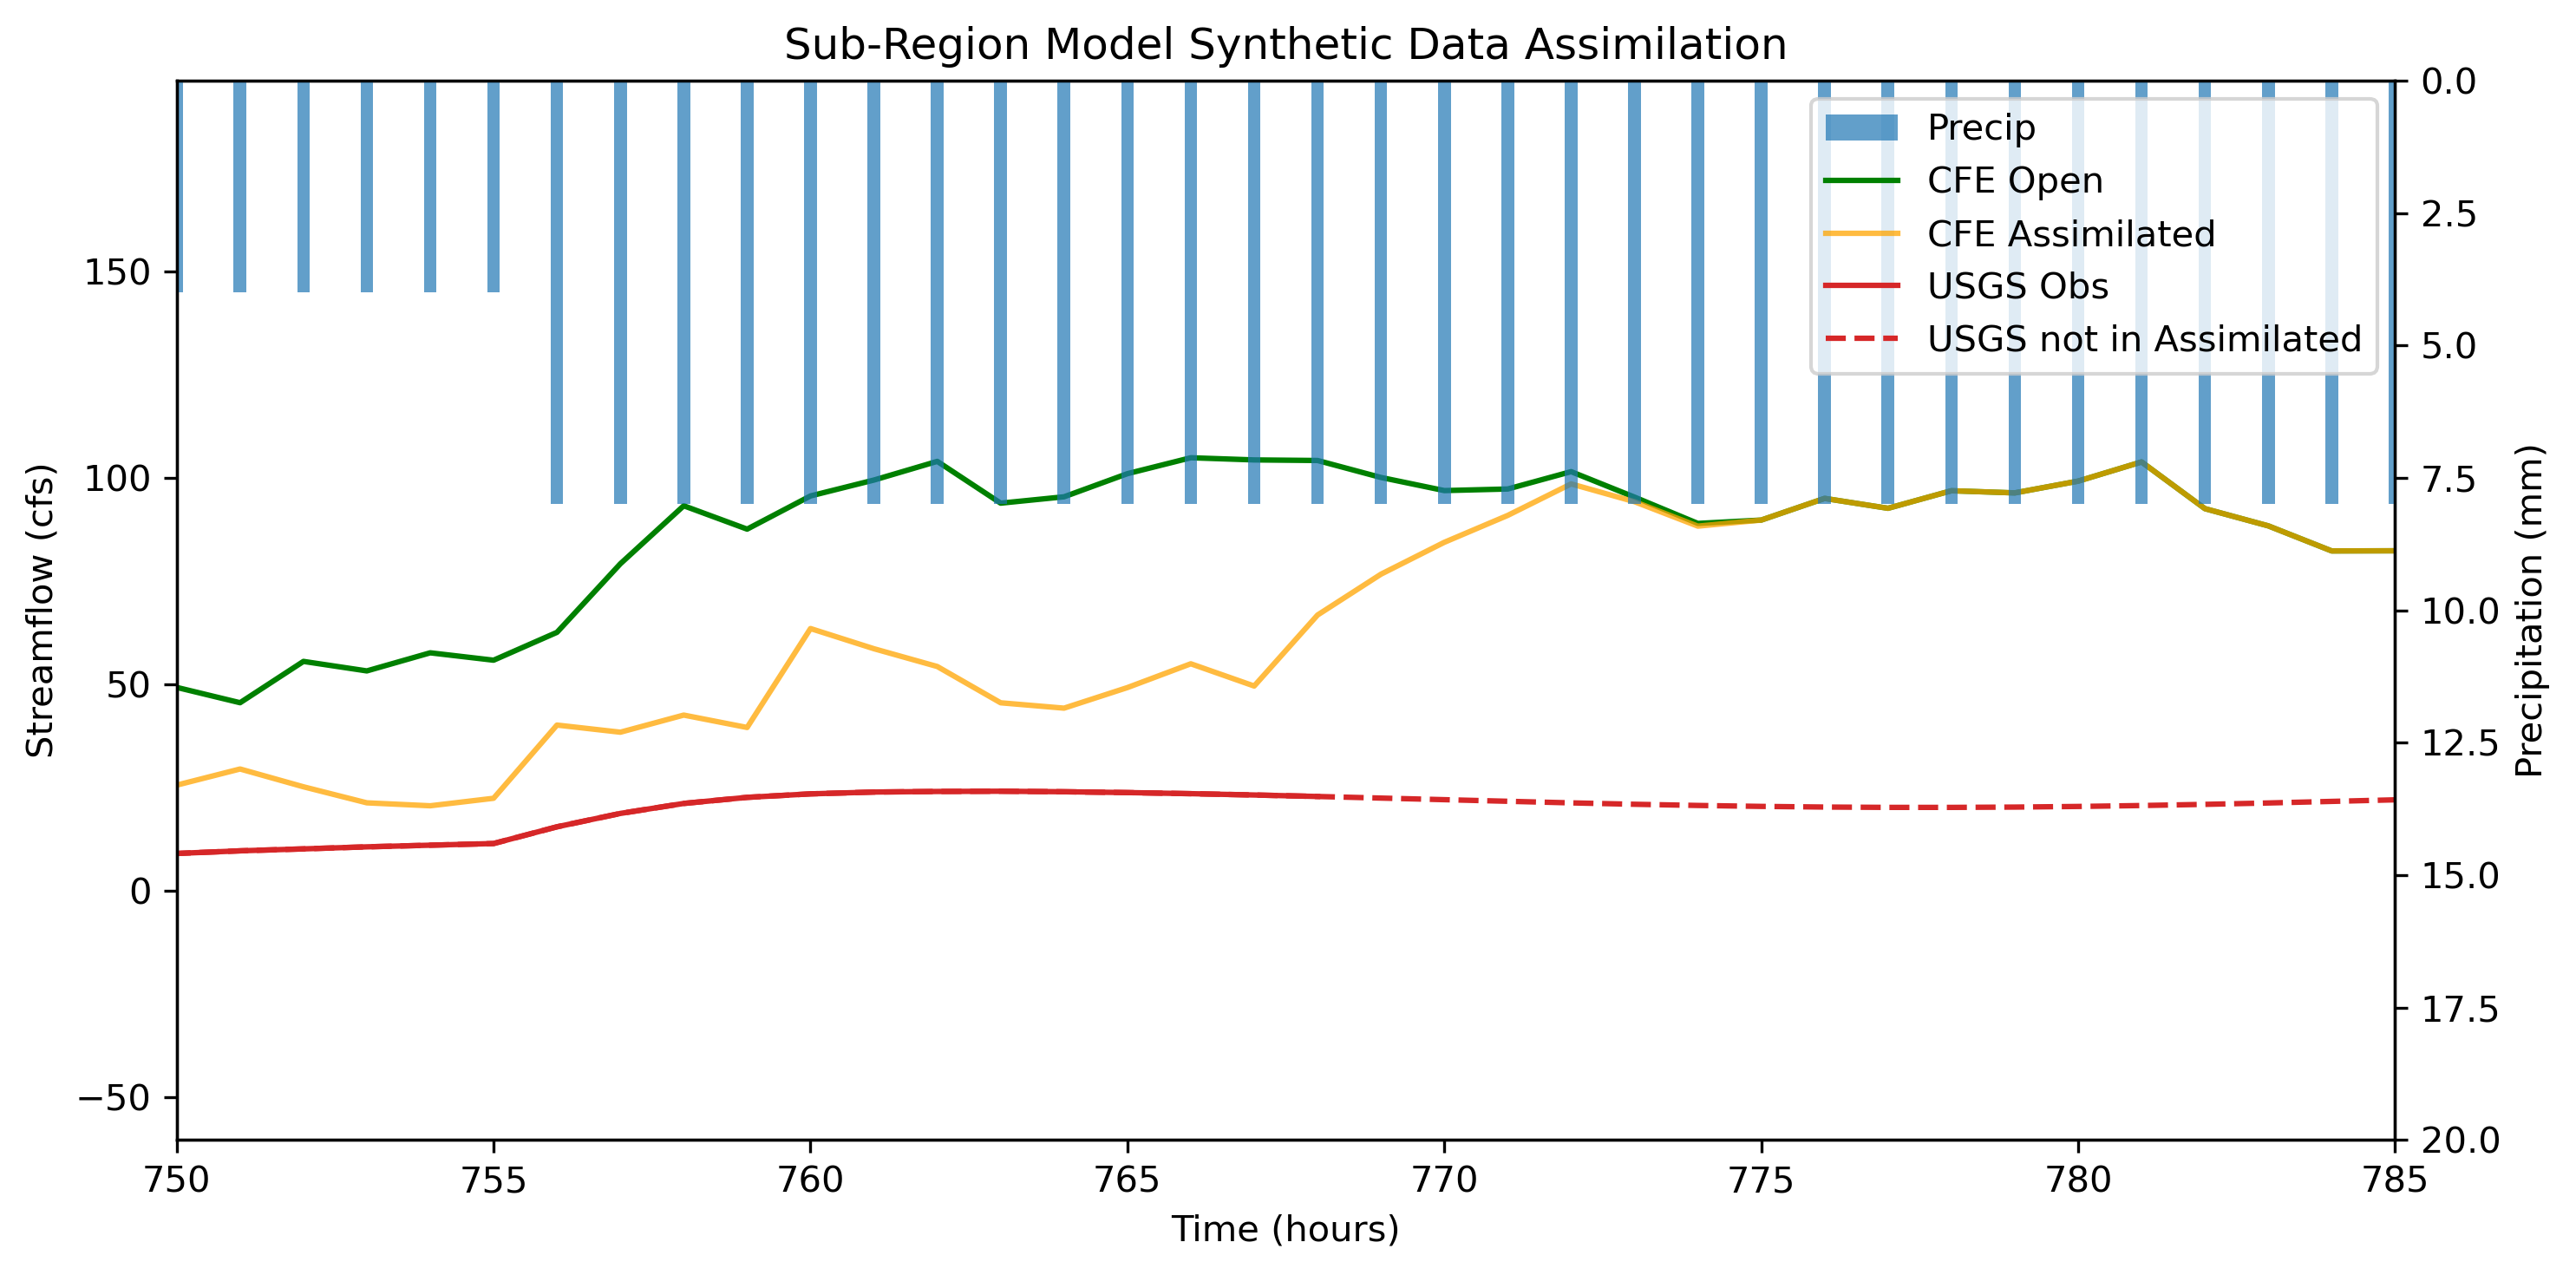

In [8]:
istart_plot=0
istart_plot_2=769
iend_plot=786
x = list(range(istart_plot, iend_plot))

Date_list = []
df_forcing['time'] = pd.to_datetime(df_forcing['time'], infer_datetime_format=True) 

fig, ax1 = plt.subplots(figsize = (10,5), dpi=300)

ax2 = ax1.twinx()

ax1.set_xlabel('Time (hours)')
ax1.set_ylabel('Streamflow (cfs)')
ax2.set_ylabel('Precipitation (mm)')
ax2.set_ylim(0,20,1)
ax2.invert_yaxis()
#ax1.set_ylim(0,50,1)
plt.xlim(750,785)

plt.title('Sub-Region Model Synthetic Data Assimilation')
Precip = ax2.bar(x, df_forcing['APCP_surface_0'],width=0.2,alpha=0.7, color="tab:blue", label = 'Precip')
#ax1.plot(x, cfePeturbed[istart_plot:iend_plot], color = 'tab:orange', label = 'CFE Peturbed')
Open, = ax1.plot(x, cfeOpen[istart_plot:iend_plot], color = 'green', label = 'CFE Open')
Analysis, = ax1.plot(x, cfeAnalysis[istart_plot:iend_plot], color = 'orange', alpha=0.75, label = 'CFE Assimilated')
Obs, = ax1.plot(OBSERVATIONS_LIST[istart_plot:769], color = 'tab:red', label = 'USGS Obs')
Obs2, = ax1.plot(OBSERVATIONS_LIST[istart_plot:iend_plot], color = 'tab:red', linestyle='dashed', label = 'USGS not in Assimilated')
#ax1.plot(x, cfeEnKF[istart_plot:iend_plot], color = 'tab:blue', label = 'EnKF')

#ax1.set_xlim([date(2017, 5, 15), date(2017, 6, 15)]) ## Customize date range for all plots
#ax1.tick_params(axis='x', labelrotation = 45)

plt.legend(handles = [Precip,Open,Analysis,Obs,Obs2], loc='upper right', bbox_to_anchor=(0.5, 0.5, 0.5, 0.5))

#plt.savefig("WorkingDA_7-19.png")
fig.tight_layout()
ax1.margins(x=0)

plt.show()


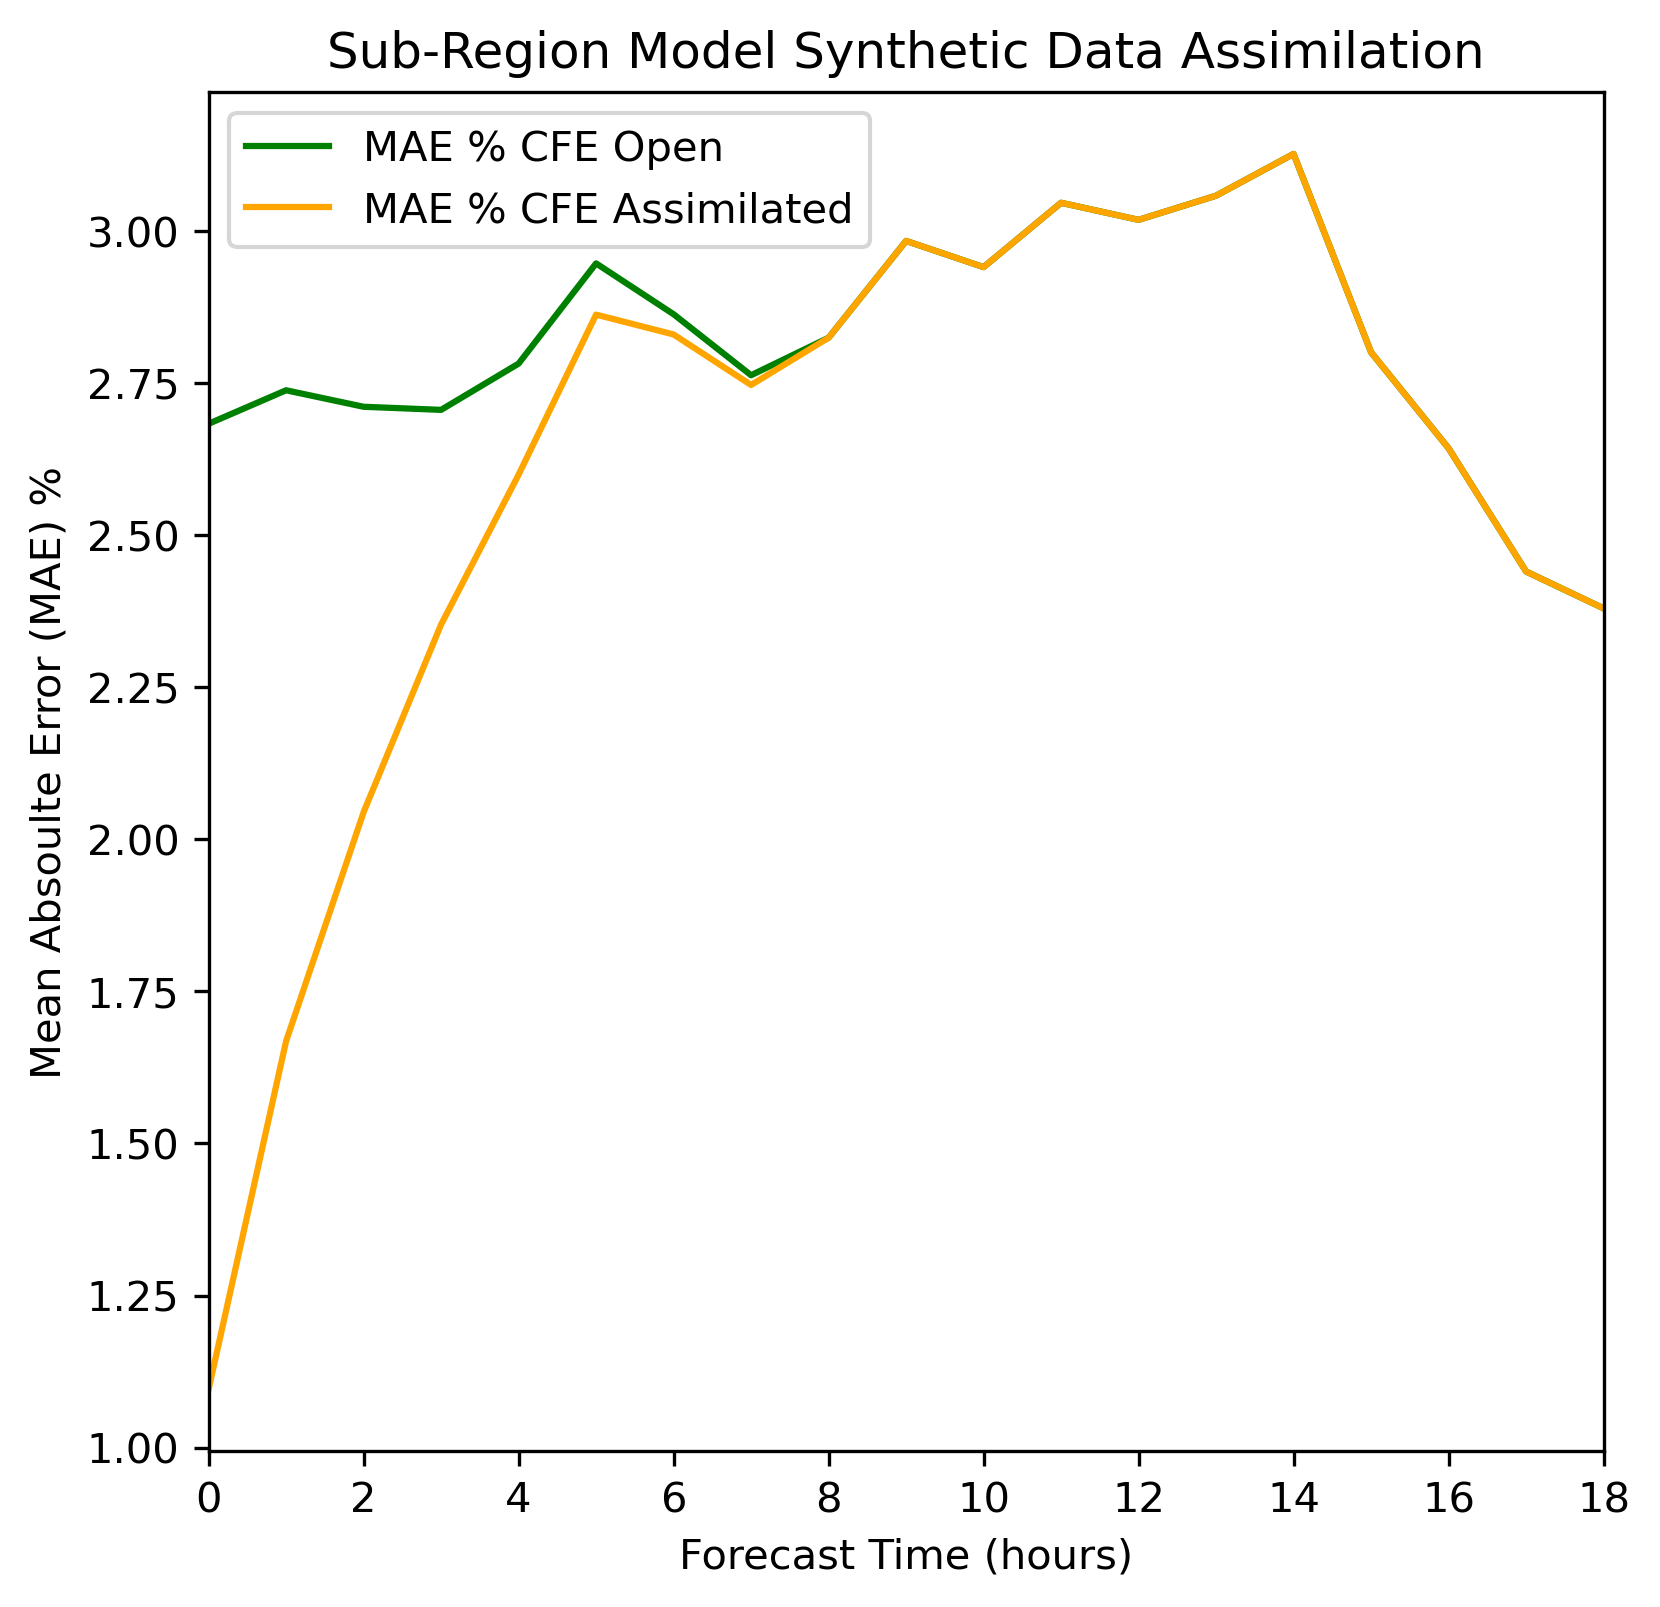

In [9]:
fig = plt.subplots(figsize = (6,6), dpi=300)
CFE_open=cfeOpen_ensa_mean
CFE_analysis=cfeanalys_ensa_mean
plt.title('Sub-Region Model Synthetic Data Assimilation')
plt.plot(CFE_open, color = 'green', label = 'MAE % CFE Open')
plt.plot(CFE_analysis, color = 'orange', label = 'MAE % CFE Assimilated')
plt.xlim(0,18)
plt.xlabel('Forecast Time (hours)')
plt.ylabel('Mean Absoulte Error (MAE) %')
plt.legend()
plt.show()



In [10]:
df=pd.DataFrame({"obs":OBSERVATIONS_LIST,"cfeAnalysis":cfeAnalysis,"cfeOpen":cfeOpen})
df.dropna(axis=0, inplace=True)
df.reset_index(drop=True, inplace=True)

In [11]:
# CFE open eval
nse_open=he.evaluator(he.nse,df["obs"],df["cfeOpen"])
pbias=he.evaluator(he.pbias,df["obs"],df["cfeOpen"])
kge_open, r_open, alpha_open, beta_open = he.evaluator(he.kge, df["obs"],df["cfeOpen"])
print("r_open=",r_open[0])
print("KGE_open=",kge_open[0])
print("NSE_open=", nse_open[0])
print("PBias=", pbias[0])

# CFE Analysis
nse_analysis=he.evaluator(he.nse,df["obs"],df["cfeAnalysis"])
pbias_analysis=he.evaluator(he.pbias,df["obs"],df["cfeAnalysis"])
kge_analysis, r_analysis, alpha_analysis, beta_analysis = he.evaluator(he.kge, df["obs"],df["cfeAnalysis"])
print("r_analysis=",r_analysis[0])
print("KGE_analysis=",kge_analysis[0])
print("NSE_analysis=", nse_analysis[0])
print("PBias=", pbias_analysis[0])

print("mean_obs=",np.mean(df["obs"]))
print("STD_obs=",np.std(df["obs"]))
print("mean_open=",np.mean(df["cfeOpen"]))
print("STD_open=",np.std(df["cfeOpen"]))
print("mean_analysis=",np.mean(df["cfeAnalysis"]))
print("STD_analysis=",np.std(df["cfeAnalysis"]))

r_open= 0.9752711532378185
KGE_open= -0.0767505289500583
NSE_open= -0.8777810226868932
PBias= 84.00853906632571
r_analysis= 0.7058811397176469
KGE_analysis= 0.10698666579917282
NSE_analysis= 0.15677825637115328
PBias= 63.09820849921553
mean_obs= 7.82998928152997
STD_obs= 11.330467618341043
mean_open= 48.96356445483878
STD_open= 34.65822995885161
mean_analysis= 21.218452988558894
STD_analysis= 25.71078763639764
